# Extracting New York Subway lines from tweets
In 2018, the Metropolitan Transit Authority made a splash by very publicly hiring a new team of public-facing employees. Subway service has notably declined in New York City, as officials opted to spend on high-profile new lines and station remodeling instead of desperately-needed maintanance. Making matters worse was the very public feud between New York Governor Andrew Cuomo and New York City Mayor Bill DiBlasio. Ownership of the quasi-public MTA is a complicated issue, as its jurisdiction extends beyond the city limits (to say nothing of the financial implications of its performance for the entire state). 

Anyways, while it remains unclear when the subway will once again run reliably, these new hires meant a significantly improved social media team. The official MTA twitter feed (@NYCTSubway, for some reason) no longer only tweets cryptic, formulaic messages with vague warnings. Service advisories are more timely and somewhat less opaque. The account now also responds to individual tweets complaining about service.

So what can we learn from the MTA's tweets (and mentions)?

## Parsing the tweets
Using [Get Old Tweets](https://github.com/Jefferson-Henrique/GetOldTweets-python), a straightforward Python wrapper for the Twitter API, I downloaded every tweet available containing 'nyctsubway'. (The module is set up so that this returns tweets from and to the search term.)

The most basic question when looking at the MTA tweets is which lines get mentioned the most. We will explore what getting lots of mentions actually means later, but first we need to figure out which tweets mention which trains.

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import spacy 

## Data cleaning
We want to look at the raw text of a tweet, and EDA revealed a few common features we wouldn't need. The `custom_process` function does the following:
- Skips any tweet with 'swarmapp' in it (Swarm geotags often include subway lines and automatically mention NYCTSubway but don't seem relevent
- Removes any HTTP links
- Removes 'n/b' and 's/b', common shorthand for "northbound" and "southbound" that complicate the parsing process
- Removes selected punctuation ('^' and '$' are left in)
- Replaces '/' with a space (subway lines are often concatenated with a slash)
- Removes 'nyctsubway' (it's just noise!)

In [2]:
# processes text for vectorizing
def custom_process(text):
    
    t = unidecode(text)
    if 'swarmapp' in t:
        return 'skip'
    
    # remove links
    t = re.sub(r'http:\S+', '', t)
    t = re.sub(r'https:\S+', '', t)
    
    # remove 'n/b' and 's/b'
    t= re.sub(r'[ns]\/b', '', t)
    
    # remove selected punctuation
    punc = r'[!"#%&\'*+,-.:;<=>?@\[\\\]_`{|}~\(\)]'
    t = re.sub(punc, '', t)
    t = re.sub(r'\/', ' ', t)
    
    # remove 'nyctsubway'
    t = ' '.join([w for w in t.split() if w.lower() not in ['nyctsubway']])

    return t

## Data imports
Reading in previously scraped tweets, parsed as will be described further down.

In [3]:
# converting 'x' in 'tag' to actual train lines
def convert_x_tags(row):
    tag = str(row['tag']).lower()
    if tag == 'x':
        return str(row['text']).lower()
    else:
        return tag
    
# creating 'match' feature -- finds 'len' of 1 where 'confirmed_tag' is ''
def find_null_match(row):
    if row['len'] == 1:
        if str(row['text']).lower() == row['confirmed_tag']:
                return 1
        else:
            return 0
    else:
        return 0

In [4]:
tagged_trigrams = pd.read_csv('trigrams_10k_tagged.csv').drop('Unnamed: 7', 1)
tagged_trigrams['confirmed_tag'] = tagged_trigrams.apply(convert_x_tags, 1)
tagged_trigrams['confirmed_tag'] = tagged_trigrams['confirmed_tag'].map(lambda x: '' if x == 'nan' else x)
tagged_trigrams['match'] = tagged_trigrams.apply(find_null_match, 1)

sen_tags = tagged_trigrams[['sentence','confirmed_tag'
             ]].groupby('sentence').sum().reset_index().rename(columns={'confirmed_tag':'sentence_tag'})
tagged_trigrams = pd.merge(tagged_trigrams, sen_tags, on='sentence')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
spacy_10k_full = pd.read_csv('spacy_ngrams_10k_full.csv')

In [6]:
# 10k 3grams with confirmed tags, spacy info and match
spacy_10k_tagged = pd.merge(
    tagged_trigrams[[
        'sentence','text_last','text','text_next','confirmed_tag','sentence_tag', 'match'
    ]],
    spacy_10k_full.drop(['len','real_train'], 1),
         on=['sentence','text_last','text','text_next'], how='left').drop_duplicates().rename(
columns={'sentence':'tweet', 'sentence_tag':'tweet_tag'})

In [7]:
# add 'prelim_tag' -- unconfirmed train tag
def prelim_tag(t):
    tag = str(t).lower()
    if (len(tag) == 1) and (tag in 'abcdefgjlmnqrwz1234567'):
        return tag
    else:
        return 'none'

In [8]:
spacy_10k_tagged['prelim_tag'] = spacy_10k_tagged['text'].map(prelim_tag)

## Approaching the problem
NYC Subway train lines are single characters: the digits 1-7 and the letters a-g, j, l, m, n, q, r, w and z. For some of these lines, finding mentions is straightforward. It's likely a tweet at or from the MTA with a lone 'Z' or 'Q' is talking about the Broad St. and Broadway express trains respectively. But 'W' can be the W train or short for "with", and our cleaning function turns the common "j/k" into a hanging 'J' which does not refer to a train.

The digits are even more complicated. Of course, numbers can be hours, months, dollars or any other quantity. But also "3 trains" could refer to the train line or a commuter annoyed at the number of express trains that have passed their station while they wait for the local.

The biggest challenge of all, of course, is the A-train. The 8th Avenue express shares its name with a ubiquitous article that appears on its own far more than it actually refers to a subway line.

## How to Add Context
The single characters on their own are not going to work. We need to preserve the context.

The most basic approach would be to just vectorize the entire tweet into binary features. Every word in the entire vocabulary of tweets gets its own column, and every tweet gets a 0 or a 1 depending on whether or not that word appears in the tweet. It's a good start to solving the problem, but it doesn't go far enough. Not only do we want to know which words appear in which tweets, we also want to know how far words are from the mention of the train line.

A more advanced approach is to split the tweet into three word chunks ("3-grams") of a word and the words which precede and follow it. This strategy allows us to model common syntax patterns. For example, tweets often refer "the 4 line" or "W trains", which helps us differentiate from cases where "W" is short for "with" or when someone is saying a train is four minutes away.

Our data set is roughly 10000 tweets split into trigrams and manually tagged when the middle word mentions a train.

### A look at the most common words that precede and follow the mention of a train in a tweet in our data:

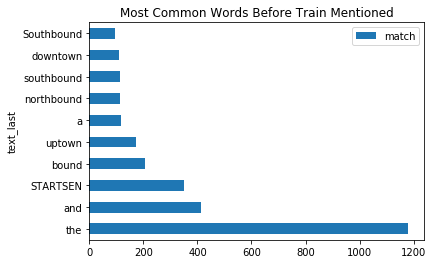

In [9]:
spacy_10k_tagged[(spacy_10k_tagged['match'] == 1)][['text_last', 'match']].groupby('text_last').count().sort_values('match', ascending=False).head(10).plot(kind='barh', title='Most Common Words Before Train Mentioned');

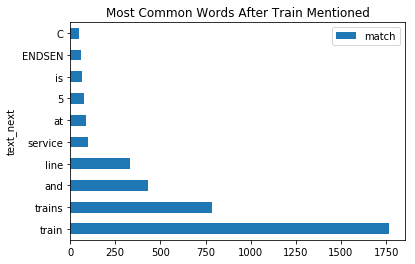

In [10]:
spacy_10k_tagged[(spacy_10k_tagged['match'] == 1)][['text_next', 'match']].groupby('text_next').count().sort_values('match', ascending=False).head(10).plot(kind='barh', title='Most Common Words After Train Mentioned');

Not only is this fundamentally more precise than looking at the whole tweet at once, it also allows us to identify multiple trains mentioned in a single tweet.

## EDA

A brief look at the data.

In [11]:
# how many tweets?
spacy_10k_tagged.tweet.nunique()

9788

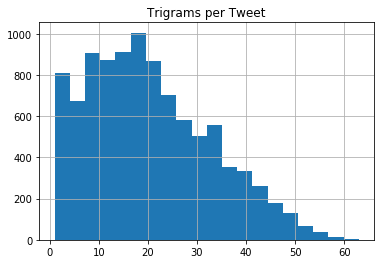

In [12]:
# trigrams per tweet?
spacy_10k_tagged[['tweet','text_last']].groupby('tweet').count().hist(bins=20)
plt.title('Trigrams per Tweet');

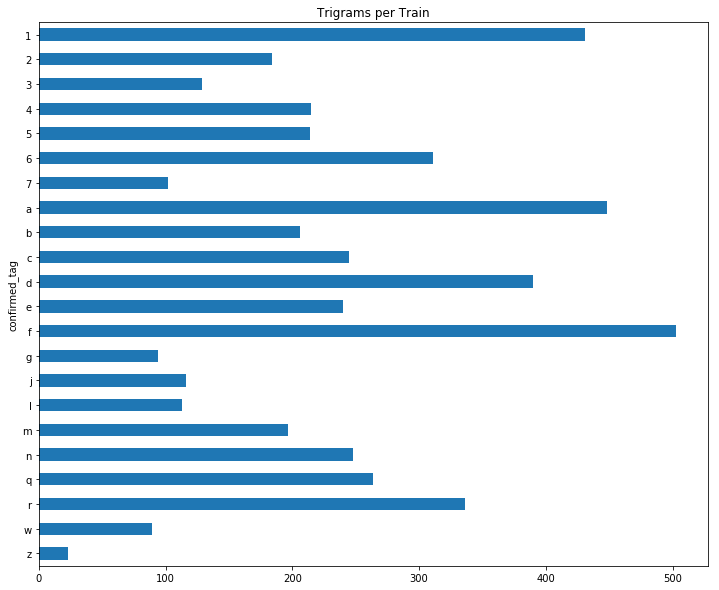

In [13]:
# trigrams per train?
spacy_10k_tagged[spacy_10k_tagged['confirmed_tag'] != ''][[
    'confirmed_tag','match']].groupby('confirmed_tag').count(
    ).sort_index(ascending=False).plot(kind='barh', figsize=(12,10), legend=False)
plt.title('Trigrams per Train');

## How good does our model have to be?
The trigram approach raises a question as to how smart the model really needs to be. If we limit (for now) our scope to single character mentions -- '4' but not 'four', 'N' 'W' but not 'NW -- how much information do we lose if we just count every mention? (Did I really need to spend a few hours tagging 10000 tweets?)

### So what is our specificity?

In [14]:
# subsetting data on 'prelim_tag' -- single character mentions that could be train lines
# counting 'match' -- 1 is a confirmed train mention, 0 is a false positive
spacy_10k_tagged[spacy_10k_tagged['prelim_tag'] != 'none'].match.value_counts()

1    5094
0    5064
Name: match, dtype: int64

Our specificity is about 0.5 across all train lines.

### Specificity per line

In [15]:
hits_raw = {}
hits_norm = {}
for t in 'abcdefgjlmnqrwz1234567':
    matches_raw = spacy_10k_tagged[
        spacy_10k_tagged['text'].str.lower() == t].match.value_counts(normalize=False, sort=False)
    matches_norm = spacy_10k_tagged[
        spacy_10k_tagged['text'].str.lower() == t].match.value_counts(normalize=True, sort=False)
    for m in ['_raw','_norm']:
        if len(eval(f'matches{m}')) == 1:
            eval(f'hits{m}')[t] = dict(zip(['hit','miss'], [eval(f'matches{m}')[1],0]))
        else:
            eval(f'hits{m}')[t] = dict(zip(['miss','hit'], eval(f'matches{m}')))

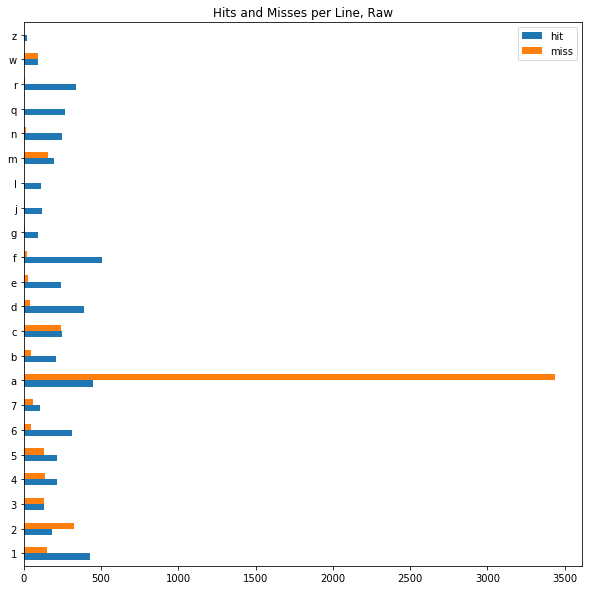

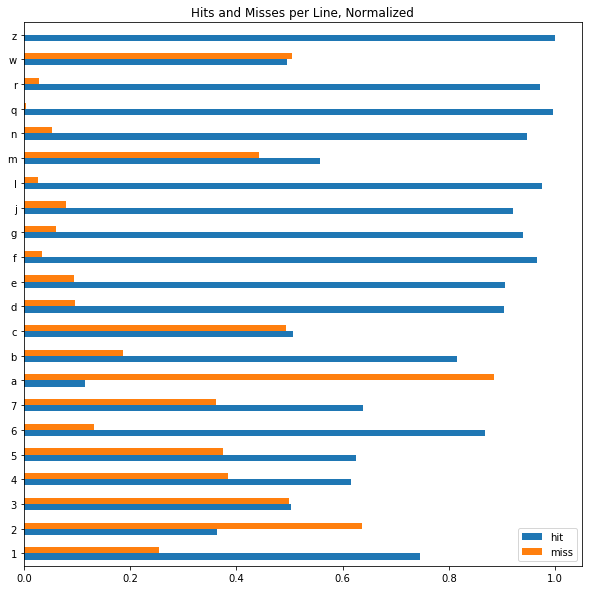

In [16]:
# percentage of hits and misses by line
pd.DataFrame(hits_raw).T.plot(kind='barh', figsize=(10,10), title='Hits and Misses per Line, Raw');
pd.DataFrame(hits_norm).T.plot(kind='barh', figsize=(10,10), title='Hits and Misses per Line, Normalized');

It's clear there's a wide range of specificity across different lines, something I mentioned earlier.

In [17]:
# Numerically...
pd.concat([pd.DataFrame(hits_raw).T.rename(columns={'hit':'hit_raw','miss':'miss_raw'}), pd.DataFrame(hits_norm).T], 1).sort_values('hit')

hit_raw  miss_raw       hit      miss
a      448      3439  0.115256  0.884744
2      184       322  0.363636  0.636364
w       89        91  0.494444  0.505556
3      129       128  0.501946  0.498054
c      245       238  0.507246  0.492754
m      197       156  0.558074  0.441926
4      214       134  0.614943  0.385057
5      213       128  0.624633  0.375367
7      102        58  0.637500  0.362500
1      431       147  0.745675  0.254325
b      206        47  0.814229  0.185771
6      309        47  0.867978  0.132022
d      390        42  0.902778  0.097222
e      240        25  0.905660  0.094340
j      116        10  0.920635  0.079365
g       94         6  0.940000  0.060000
n      248        14  0.946565  0.053435
f      503        18  0.965451  0.034549
r      336        10  0.971098  0.028902
l      113         3  0.974138  0.025862
q      264         1  0.996226  0.003774
z       23         0  1.000000  0.000000

'A' is only right about 12% of the time, while '2' clocks in at about 36%. A number of trains hover between 50% and 60%. A small majority clear %80 in our data, but it's obvious we need to do use the trigram context.

## Modeling with trigrams

Still, how well can we do just predicting whether or not a single character mention is a match, given the trigram and, for good measure, the position of the main word in the tweet?

In [18]:
# prepping for modeling

# subset data
df = spacy_10k_tagged[spacy_10k_tagged['text'].map(len) == 1].dropna()[[
    'text_last', 'text', 'text_next', 'position', 'match']]

# lower all 'text' columns
for c in df.columns:
    if 'text' in c:
        df[f'{c}_lower'] = df[c].map(lambda x: x.lower())
        
# make dummies of text columns, subsetting modeling columns
df_dummies = pd.get_dummies(df.drop(['text_last', 'text', 'text_next',], 1),
                  columns=([c for c in df.columns if 'lower' in c]))

In [19]:
# modeling
X = df_dummies.drop('match', 1)
y = df_dummies['match']

lr = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y)

To prevent data leakage between train and test sets, the test features must be equalized to the training features.

In [20]:
# equalize features in X_train and X_test
X_test = X_test[[c for c in X_test.columns if c in X_train.columns]]

for c in X_train.columns:
    if c not in X_test.columns:
        X_test[c] == 0

In [21]:
# model
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Results

Straightforward accuracy.

In [22]:
print(f'Train score: {lr.score(X_train, y_train)}')
print(f'Test score: {lr.score(X_test, y_test)}')

Train score: 0.9681889763779528
Test score: 0.9562204724409449


Confusion matrix, via heatmap.

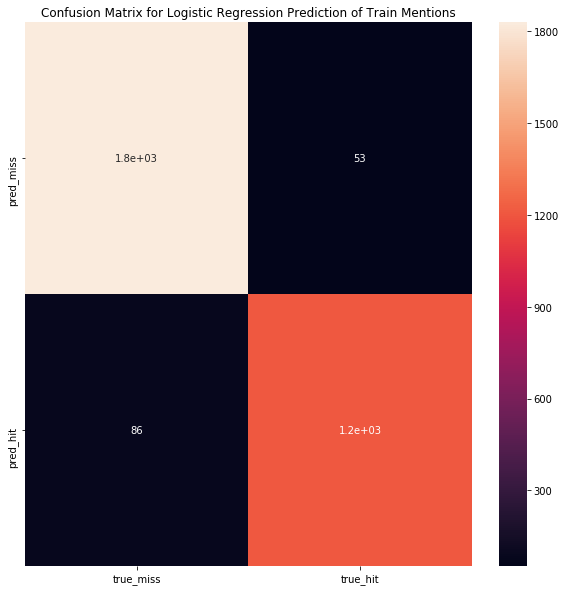

In [23]:
pred = lr.predict(X_test)
conf = confusion_matrix(y_test, pred)
plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, xticklabels=['true_miss', 'true_hit'], yticklabels=['pred_miss', 'pred_hit']);
# sns.heatmap(conf, annot=True)
plt.title('Confusion Matrix for Logistic Regression Prediction of Train Mentions');

Classification report.

In [24]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96      1883
          1       0.96      0.93      0.95      1292

avg / total       0.96      0.96      0.96      3175



In [25]:
# reassembles prediction with y_test and X_test to see what went wrong
def return_rows(y_true, pred, df):
    
    # pull y_true index
    y_rows = y_true.index
    
    # make df of true values and predicted values
    compare = pd.concat(
        [pd.DataFrame(y_true), pd.DataFrame(pred).set_index(y_rows)], 1)
    
    # rename columns
    compare.columns = ['actual', 'predicted']
    
    # make feature for accuracy
    compare['right'] = compare.apply(lambda x: True if x['actual'] == x['predicted'] else False, 1)
    compare['wrong'] = compare['right'].map(lambda x: not x)
    
    # subset df on index for 'match' == 0
    return pd.concat([df.loc[y_rows], compare[['right', 'wrong']]], 1)

A little more clearly: `prelim_tag` is the single character mention from the original tweet. The model predicts whether it is or is not referring to a train in the context of its trigram. Below, we see the number of times the model is right or wrong in its prediction.

In [26]:
wrong = return_rows(y_test, pred, spacy_10k_tagged)
wrong[['prelim_tag', 'right', 'wrong']].groupby('prelim_tag').sum()

right  wrong
prelim_tag              
1           142.0   16.0
2           122.0    6.0
3            53.0    5.0
4            91.0    4.0
5            61.0    6.0
6            86.0    5.0
7            41.0    4.0
a           927.0   52.0
b            65.0    7.0
c            93.0    8.0
d           111.0    5.0
e            66.0    4.0
f           131.0    3.0
g            23.0    2.0
j            28.0    1.0
l            36.0    0.0
m            93.0    2.0
n            70.0    5.0
none        606.0    1.0
q            63.0    1.0
r            87.0    0.0
w            38.0    2.0
z             3.0    0.0

## Cross-validation

Running this five more times (with new train/test splits each time) to support the above results.

In [27]:
# custom script to account for the need for feature equalization
def cross_val(X, y):
    lr = LogisticRegression()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # equalize features in X_train and X_test
    X_test = X_test[[c for c in X_test.columns if c in X_train.columns]]

    for c in X_train.columns:
        if c not in X_test.columns:
            X_test[c] == 0
    
    # model
    lr.fit(X_train, y_train)
    
    print(f'Train score: {lr.score(X_train, y_train)}')
    print(f'Test score: {lr.score(X_test, y_test)}')
    
    pred = lr.predict(X_test)
    print(classification_report(y_test, pred))
    return

In [28]:
run = 1
while run < 6:
    print(f'run number {run}')
    cross_val(X, y)
    run +=1

run number 1
Train score: 0.968503937007874
Test score: 0.9584251968503937
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      1891
          1       0.97      0.93      0.95      1284

avg / total       0.96      0.96      0.96      3175

run number 2
Train score: 0.9686089238845145
Test score: 0.9577952755905512
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      1872
          1       0.96      0.94      0.95      1303

avg / total       0.96      0.96      0.96      3175

run number 3
Train score: 0.9682939632545932
Test score: 0.9628346456692913
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      1894
          1       0.96      0.94      0.95      1281

avg / total       0.96      0.96      0.96      3175

run number 4
Train score: 0.9694488188976378
Test score: 0.952755905511811
             precision    recall  f1-score   support


## Conclusion, discussion and next steps

I started this project with the intention of building an app which tracks which trains people are mentioning on Twitter, and for that purpose it works as is. Train and test scores are both high and comparable. Most importantly, mistakes are evenly distributed across the train lines in proportion with their appearance. ('W' is probably the most concerning at the moment, but this has as much to do with its rare appearance as anything.)

This analysis originally intended to add more context by using the `Spacy` package to tag tweets with simple and detailed parts of speech, as well as syntactic dependency to make an even more accurate model. However, not only does the straightforward trigram model perform very well, the Spacy features did not increase performance.

Granted, this model relies on the specific syntax of the MTA in my captured window, and probably somewhat on the nature of the tweets in this time as well. This were sampled in the summer of 2018; the coming months will probably feature fewer complaints about air conditioning on the 1 train and fewer pleas to Cynthia Nixon for salvation.

The biggest blind spot right now is probably mentions that break the single character format, whether bunched lines ('NQRW'), parsing errors ('Qtrain') or literal spellings ('four'). But given the performance of the current model, I am comfortable shifting my efforts to building the app.